# Face alignment in images and videos


**Mount your Google drive folder on Colab**

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


**Load source image (only single face allowed)**

In [ ]:
import imageio
import numpy as np
from skimage.transform import resize
import warnings
from argparse import Namespace
import time
import sys
from PIL import Image

z1 = []
z2 = []
b = []
lm_copy = np.array(b)




warnings.filterwarnings("ignore")


#image_path = '/content/gdrive/MyDrive/data/frame10.jpg'
#source_image = Image.open(image_path)

# Load video
#target_video = imageio.mimread('/content/gdrive/My Drive/motion-supervised-co-segmentation/04.mp4')

# Resize image to 256x256 if needed
#source_image = source_image.resize((256,256),Image.ANTIALIAS)

#source_image

### Align Image

Note: in this notebook we'll run alignment on the input image. 

In [ ]:
!wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
!bzip2 -dk shape_predictor_68_face_landmarks.dat.bz2

--2022-07-19 12:47:06--  http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
Resolving dlib.net (dlib.net)... 107.180.26.78
Connecting to dlib.net (dlib.net)|107.180.26.78|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64040097 (61M)
Saving to: ‘shape_predictor_68_face_landmarks.dat.bz2.1’

shape_predictor_68_ 100%[===================>]  61.07M  21.2MB/s    in 2.9s    

2022-07-19 12:47:09 (21.2 MB/s) - ‘shape_predictor_68_face_landmarks.dat.bz2.1’ saved [64040097/64040097]

bzip2: Output file shape_predictor_68_face_landmarks.dat already exists.


In [ ]:
import scipy
import scipy.ndimage
import dlib
from PIL import Image

def get_landmark(filepath, predictor):
  detector = dlib.get_frontal_face_detector()
  img = dlib.load_rgb_image(filepath)
  dets = detector(img, 1)

  for k, d in enumerate(dets):
    shape = predictor(img, d)

  t = list(shape.parts())
  a = []
  for tt in t:
    a.append([tt.x, tt.y])
  lm = np.array(a)
  return lm

def align_face(filepath, predictor,x_scale=1, y_scale=1):

  lm = get_landmark(filepath, predictor)
  lm_copy = lm
  #print(lm_copy)

  lm_chin = lm[0: 17]  # left-right
  #print(lm_chin)
  lm_eyebrow_left = lm[17: 22]  # left-right
  lm_eyebrow_right = lm[22: 27]  # left-right
  lm_nose = lm[27: 31]  # top-down
  #print(lm_nose)
  lm_nostrils = lm[31: 36]  # top-down
  lm_eye_left = lm[36: 42]  # left-clockwise
  lm_eye_right = lm[42: 48]  # left-clockwise
  lm_mouth_outer = lm[48: 60]  # left-clockwise
  lm_mouth_inner = lm[60: 68]  # left-clockwise

  # Calculate auxiliary vectors.
  eye_left = np.mean(lm_eye_left, axis=0)
  print(f'Eye Left {eye_left}')
  eye_right = np.mean(lm_eye_right, axis=0)
  print(f'Eye right {eye_right}')
  eye_avg = (eye_left + eye_right) * 0.5
  eye_to_eye = eye_right - eye_left
  mouth_left = lm_mouth_outer[0]
  mouth_right = lm_mouth_outer[6]
  mouth_avg = (mouth_left + mouth_right) * 0.5
  eye_to_mouth = mouth_avg - eye_avg

  # Choose oriented crop rectangle.
  x = eye_to_eye - np.flipud(eye_to_mouth) * [-1, 1]
  x /= np.hypot(*x)
  x *= max(np.hypot(*eye_to_eye) * 2.0, np.hypot(*eye_to_mouth) * 1.8)
  x *= x_scale
  y = np.flipud(x) * [-y_scale, y_scale]
  c = eye_avg + eye_to_mouth * 0.1
  quad = np.stack([c - x - y, c - x + y, c + x + y, c + x - y])
  qsize = np.hypot(*x) * 2

  # read image
  img = Image.open(filepath)

  output_size = 256
  transform_size = 256
  enable_padding = True

  # Shrink.
  shrink = int(np.floor(qsize / output_size * 0.5))
  if shrink > 1:
    rsize = (int(np.rint(float(img.size[0]) / shrink)), int(np.rint(float(img.size[1]) / shrink)))
    img = img.resize(rsize, PIL.Image.ANTIALIAS)
    quad /= shrink
    qsize /= shrink

  # Crop.
  border = max(int(np.rint(qsize * 0.1)), 3)
  crop = (int(np.floor(min(quad[:, 0]))), int(np.floor(min(quad[:, 1]))), int(np.ceil(max(quad[:, 0]))),
      int(np.ceil(max(quad[:, 1]))))
  z1.append(int(np.floor(min(quad[:, 0]))))
  z1.append(int(np.floor(min(quad[:, 1]))))
  z1.append(int(np.ceil(max(quad[:, 0]))))
  z1.append(int(np.ceil(max(quad[:, 1]))))
  #print(crop)

  crop = (max(crop[0] - border, 0), max(crop[1] - border, 0), min(crop[2] + border, img.size[0]),
      min(crop[3] + border, img.size[1]))
  
  z2.append(max(crop[0] - border, 0))
  z2.append(max(crop[1] - border, 0))
  z2.append(crop[2])
  z2.append(crop[3])
  #print(crop)
  
  if crop[2] - crop[0] < img.size[0] or crop[3] - crop[1] < img.size[1]:
    img = img.crop(crop)
    quad -= crop[0:2]

  # Pad.
  pad = (int(np.floor(min(quad[:, 0]))), int(np.floor(min(quad[:, 1]))), int(np.ceil(max(quad[:, 0]))),
        int(np.ceil(max(quad[:, 1]))))
  pad = (max(-pad[0] + border, 0), max(-pad[1] + border, 0), max(pad[2] - img.size[0] + border, 0),
        max(pad[3] - img.size[1] + border, 0))
  if enable_padding and max(pad) > border - 4:
    pad = np.maximum(pad, int(np.rint(qsize * 0.3)))
    img = np.pad(np.float32(img), ((pad[1], pad[3]), (pad[0], pad[2]), (0, 0)), 'reflect')
    h, w, _ = img.shape
    y, x, _ = np.ogrid[:h, :w, :1]
    mask = np.maximum(1.0 - np.minimum(np.float32(x) / pad[0], np.float32(w - 1 - x) / pad[2]),
              1.0 - np.minimum(np.float32(y) / pad[1], np.float32(h - 1 - y) / pad[3]))
    blur = qsize * 0.02
    img += (scipy.ndimage.gaussian_filter(img, [blur, blur, 0]) - img) * np.clip(mask * 3.0 + 1.0, 0.0, 1.0)
    img += (np.median(img, axis=(0, 1)) - img) * np.clip(mask, 0.0, 1.0)
    img = Image.fromarray(np.uint8(np.clip(np.rint(img), 0, 255)), 'RGB')
    quad += pad[:2]

  # Transform.
  img = img.transform((transform_size, transform_size), Image.QUAD, (quad + 0.5).flatten(), Image.BILINEAR)
  if output_size < transform_size:
    img = img.resize((output_size, output_size), Image.ANTIALIAS)

  # Return aligned image.
  return img


In [ ]:
def run_alignment(src_img):
  import dlib
  predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")
  aligned_image = align_face(image_path, predictor=predictor,x_scale=1.0, y_scale=1.0)
  print("Aligned image has shape: {}".format(aligned_image.size))
  return aligned_image



In [ ]:
from moviepy.editor import VideoFileClip
from moviepy.editor import *
from pathlib import Path
from datetime import timedelta
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
import os

frames_list=[]


SAVING_FRAMES_PER_SECOND = 24

for image in os.listdir('/content/gdrive/MyDrive/data/'):
  os.remove(f'/content/gdrive/MyDrive/data/{image}')
  #print(f' Removed image at /content/gdrive/MyDrive/data/{image}')

for image in os.listdir('/content/gdrive/MyDrive/data2/'):
  os.remove(f'/content/gdrive/MyDrive/data2/{image}')
  #print(f' Removed image at /content/gdrive/MyDrive/data/{image}')



video = VideoFileClip("/content/gdrive/MyDrive/video9.mp4")
saving_frames_per_second = min(video.fps, SAVING_FRAMES_PER_SECOND)
step = 1 / video.fps if saving_frames_per_second == 0 else 1 / saving_frames_per_second


counter = 0;

for current_duration in np.arange(0, video.duration, step):
   counter+=1
   frame_filename = os.path.join("/content/gdrive/MyDrive/", f"data/frame{counter}.jpg")
   video.save_frame(frame_filename, current_duration)


In [ ]:
img_clips = []
path_list=[]
counter = 0

import cv2
from PIL import Image  
import PIL  

x1 = 0
y1 = 0
x2 = 0
y2 = 0


arr1 = []
arr2 = []
arr3 = []
arr4 = []



for image in os.listdir('/content/gdrive/MyDrive/data/'):
    if image.endswith(".jpg"):

    
        image_path = '/content/gdrive/MyDrive/data/' + image

        s_image = Image.open(image_path)

        
        if(counter < 1):
          input_image = run_alignment(s_image)
          input_image.resize((256, 256))
          input_image_RGB = input_image.convert('RGB')
          x1 = z1[0]
          y1 = z1[1]
          x2 = z1[3]
          y2 = z1[2]
          arr1.append(z1[0])
          arr2.append(z1[1])
          arr3.append(z1[2])
          arr4.append(z1[3])
          print(x1)
          print(y1)
          print(x2)
          print(y2)

        else:
         run_alignment(s_image)
         im1 = im.crop((x1, y1, y2, x2))
         arr1.append(z1[0])
         #print(arr1)
         arr2.append(z1[1])
         #print(arr2)
         arr3.append(z1[2])
         #print(arr3)
         arr4.append(z1[3])
         #print(arr4)
         #input_image.resize((256, 256))
         #input_image.thumbnail((256, 256))
         #im1 = cv2.resize(im1, (256, 256))
         input_image_RGB = im1.convert('RGB')



        im = Image.open('/content/gdrive/MyDrive/data/'+ image)
        fig = plt.figure()
        ax = fig.subplots()
        ax.imshow(im)
        minus = z1[2]/100 * 40
        rect = patches.Rectangle((z1[0], z1[1]), z1[2]-minus, z1[3], linewidth=3, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        plt.show() 
        fig.savefig(f'/content/gdrive/MyDrive/data2/frame{counter}.jpg')
        ax.clear




        imgplot = plt.imshow(s_image)
        plt.show() 
        #path_list.append(input_image)
        counter+=1
 
        print("Worked: ")
        print(counter)

 
        
        z1 = []








       

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
a_sum = 0
b_sum = 0
c_sum = 0
d_sum = 0




for i in range(len(arr1)):
  a = int(arr1[i])
  a_sum += a
  b = int(arr2[i])
  b_sum += b
  c = int(arr3[i])
  c_sum += c
  d = int(arr4[i])
  d_sum += d



arr1.sort()
arr2.sort()
arr3.sort()
arr4.sort()

med_1 = arr1[int(len(arr1)/2)]
med_2 = arr2[int(len(arr2)/2)]
med_3 = arr3[int(len(arr3)/2)]
med_4 = arr4[int(len(arr4)/2)]



print(a_sum/len(arr1))
print(b_sum/len(arr1))
print(c_sum/len(arr1))
print(d_sum/len(arr1))

752.8974358974359
24.45299145299145
1712.534188034188
984.0940170940171


752.8974358974359
24.45299145299145
1712.534188034188
984.0940170940171


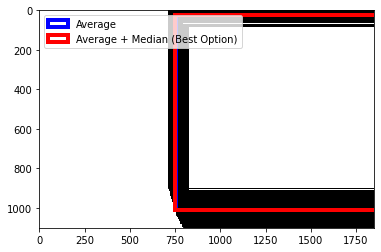

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import numpy
import math 

#print(arr1)
#print(arr2)
#print(arr3)
#print(arr4)

a_sum = 0 
b_sum = 0
c_sum = 0
d_sum = 0


fig = plt.figure()
ax = fig.add_subplot(111)

for i in range(len(arr1)):
  a = int(arr1[i])
  a_sum += a
  b = int(arr2[i])
  b_sum += b
  c = int(arr3[i])
  c_sum += c
  d = int(arr4[i])
  d_sum += d


  rect1 = matplotlib.patches.Rectangle((a, b),c, d,color ='black', fill=None)
  
  ax.add_patch(rect1)

  
plt.xlim([0, 1850])
plt.ylim([1100, 0])
print(a_sum/len(arr1))
print(b_sum/len(arr1))
print(c_sum/len(arr1))
print(d_sum/len(arr1))


rect2 = matplotlib.patches.Rectangle((a_sum/len(arr1), b_sum/len(arr1)),c_sum/len(arr1), d_sum/len(arr1),color ='blue', fill=None, linewidth=4, label="Average")
rect3 = matplotlib.patches.Rectangle(((a_sum/len(arr1)+med_1)/2, (b_sum/len(arr1)+med_2)/2), (c_sum/len(arr1)+med_3)/2, (d_sum/len(arr1)+med_4)/2,color ='red', fill=None, linewidth=4, label="Average + Median (Best Option)")
ax.add_patch(rect2)
ax.add_patch(rect3)

plt.legend(loc="upper left")
  
plt.show()

In [ ]:
counter = 0
for image in os.listdir('/content/gdrive/MyDrive/data/'):
  if image.endswith(".jpg"):

        counter+=1

    
        image_path = f'/content/gdrive/MyDrive/data/frame{counter}.jpg'
        s_image = Image.open(image_path)
        im1 = s_image.crop((a_sum/len(arr1), b_sum/len(arr1), c_sum/len(arr1), d_sum/len(arr1)))
        im1.resize((256, 256))
        input_image_RGB = im1.convert('RGB')


        im = Image.open(f'/content/gdrive/MyDrive/data/frame{counter}.jpg')
        fig, ax = plt.subplots()
        ax.imshow(im)

        rect = patches.Rectangle(((a_sum/len(arr1)+med_1)/2, (b_sum/len(arr1)+med_2)/2), (c_sum/len(arr1)+med_3)/2, (d_sum/len(arr1)+med_4)/2, linewidth=3, edgecolor='r', facecolor='none')
        print((a_sum/len(arr1)+med_1)/2)
        print((b_sum/len(arr1)+med_2)/2)
        print((c_sum/len(arr1)+med_3)/2)
        print((d_sum/len(arr1)+med_4)/2)
        ax.add_patch(rect)
        plt.show() 
        ax.clear
        imgplot = plt.imshow(s_image)
        plt.show() 
        #path_list.append(input_image)
        input_image_RGB = input_image_RGB.save(f'/content/gdrive/MyDrive/data2/frame{counter}.jpg') 
        print("Worked: ")
        print(counter)
        #print("image"+counter)
        path_list.append(f'/content/gdrive/MyDrive/data2/frame{counter}.jpg')
     
        z1 = []
        
       

for img_path in path_list:
  slide = ImageClip(img_path,duration=0.042)
  img_clips.append(slide)

video_slides = concatenate_videoclips(img_clips, method='compose')

video_slides.write_videofile("/content/gdrive/MyDrive/output_video_12.mp4", fps=24)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
counter = 0
for image in os.listdir('/content/gdrive/MyDrive/data/'):
  if image.endswith(".jpg"):

        counter+=1

        fig = plt.figure()
        ax = fig.subplots()
    
        image_path = f'/content/gdrive/MyDrive/data/frame{counter}.jpg'
        s_image = Image.open(image_path)
        im1 = s_image.crop((a_sum/len(arr1), b_sum/len(arr1), c_sum/len(arr1), d_sum/len(arr1)))
        im1.resize((256, 256))
        input_image_RGB = im1.convert('RGB')


        im = Image.open(f'/content/gdrive/MyDrive/data/frame{counter}.jpg')
        #fig, ax = plt.subplots()
        ax.imshow(im)

        rect = patches.Rectangle(((a_sum/len(arr1)+med_1)/2, (b_sum/len(arr1)+med_2)/2), (c_sum/len(arr1)+med_3)/2, (d_sum/len(arr1)+med_4)/2, linewidth=3, edgecolor='r', facecolor='none')
        print((a_sum/len(arr1)+med_1)/2)
        print((b_sum/len(arr1)+med_2)/2)
        print((c_sum/len(arr1)+med_3)/2)
        print((d_sum/len(arr1)+med_4)/2)
        ax.add_patch(rect)
        plt.show() 
        fig.savefig(f'/content/gdrive/MyDrive/data2/frame{counter}.jpg')
        ax.clear
        imgplot = plt.imshow(s_image)
        plt.show() 
        #path_list.append(input_image)
        print("Worked: ")
        print(counter)
        #print("image"+counter)
        path_list.append(f'/content/gdrive/MyDrive/data2/frame{counter}.jpg')
     
        z1 = []
        
       

for img_path in path_list:
  slide = ImageClip(img_path,duration=0.042)
  img_clips.append(slide)

video_slides = concatenate_videoclips(img_clips, method='compose')

video_slides.write_videofile("/content/gdrive/MyDrive/output_video_11.mp4", fps=24)

In [ ]:
img_clips = []
path_list=[]
counter = 0

import cv2
from PIL import Image  
import PIL  

counter = 0

for image in os.listdir('/content/gdrive/MyDrive/data/'):
    if image.endswith(".jpg"):

        
        image_path = '/content/gdrive/MyDrive/data/' + image

        x1 = 0
        y1 = 0
        x2 = 0
        y2 = 0

        print(len(z1))

        s_image = Image.open(image_path)

        if(counter > 1):          
            input_image = run_alignment(s_image)
            input_image.resize((256, 256))
            input_image_RGB = input_image.convert('RGB')  
            x1 = z1[0]    
            y1 = z1[1]
            x2 = z1[3]
            y2 = z1[2]    
        else:
          input_image_RGB = s_image.crop( (x1, y1, x2, y2) )


        #im = Image.open('/content/gdrive/MyDrive/data/'+ image)
        #fig, ax = plt.subplots()
        #ax.imshow(im)
        #rect = patches.Rectangle((z1[0], z1[1]), z1[3], z1[2], linewidth=3, edgecolor='r', facecolor='none')
        #ax.add_patch(rect)
        #plt.show() 
        #ax.clear

        imgplot = plt.imshow(s_image)
        plt.show() 
        #path_list.append(input_image)
        counter+=1

        path = "/content/gdrive/MyDrive/data/" + image
 
        input_image_RGB = input_image_RGB.save(path) 
        print("Worked: ")
        print(counter)
        path_list.append('/content/gdrive/MyDrive/data/'+ image)
        counter+=1
        

        
      
        
       

for img_path in path_list:
  slide = ImageClip(img_path,duration=0.042)
  img_clips.append(slide)

video_slides = concatenate_videoclips(img_clips, method='compose')

video_slides.write_videofile("/content/gdrive/MyDrive/output_video.mp4", fps=24)
       